In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, cross_val_score, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

import time
import psutil
import threading
from memory_profiler import memory_usage

import joblib

/home/wahba/miniconda3/envs/ml1/lib/python3.10/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


# 1.0 Dataset Preparation

## 1.1 Training and Testing Dataset Preparation

In [2]:
df = pd.read_csv('/home/wahba/Documents/nids5/test/dataset/2_Attack_only/Attacks.csv')

selected_features = [
    "Bwd Packet Length Std",
    "Bwd Packet Length Mean",
    "Bwd Packet Length Max",
    "Total Length of Fwd Packets",
    "Fwd Packet Length Max",
    "Fwd Packet Length Mean",
    "Fwd IAT Std",
    "Total Fwd Packets",
    "Fwd Packet Length Std",
    "Flow IAT Max",
    "Flow Bytes/s",
    "Flow IAT Std",
    "Bwd Packet Length Min",
    "Fwd IAT Total",
    "Label",
]

# Keep only the selected features
df = df[selected_features]

# splitting df for training and testing using stratified split
X = df.drop('Label', axis=1) # features
y = df['Label'] # target

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(X, y):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]

X_train = strat_train_set.drop("Label", axis=1)
y_train = strat_train_set["Label"]

X_test = strat_test_set.drop("Label", axis=1)
y_test = strat_test_set["Label"]

print(pd.DataFrame({
    "count (df)": df["Label"].value_counts(),
    "count (train_set)": strat_train_set["Label"].value_counts(),
    "count (test_set)": strat_test_set["Label"].value_counts(),
    "proportion": strat_train_set["Label"].value_counts(normalize=True),
})
)

             count (df)  count (train_set)  count (test_set)  proportion
Label                                                                   
DoS              193745             154996             38749    0.454985
DDoS             128016             102413             25603    0.300629
Port Scan         90819              72655             18164    0.213276
Brute Force        9152               7322              1830    0.021493
Web Attack         2143               1714               429    0.005031
Bot                1953               1562               391    0.004585


### 1.1.1 Feature Scaling for KNN

In [3]:
rbscaler = RobustScaler()

# fit and transform training data, transform testing data
X_train_scaled = rbscaler.fit_transform(X_train)
X_test_scaled = rbscaler.transform(X_test)

joblib.dump(rbscaler, '/home/wahba/Documents/nids5/test/model/multi_class/robust_scaler.joblib')

['/home/wahba/Documents/nids5/test/model/multi_class/robust_scaler.joblib']

### 1.1.2 Dataset Resampling

In [10]:
over = SMOTE(sampling_strategy={
    'Brute Force': 15000,
    'Web Attack': 8000,
    'Bot': 8000,
})

under = RandomUnderSampler(sampling_strategy={
    'DoS': 50000,
    'DDoS': 40000,
    'Port Scan': 30000
})

pipeline = Pipeline([
    ('over', over),
    ('under', under)
])

X_train_resampled, y_train_resampled = pipeline.fit_resample(X_train, y_train)
X_train_scaled_resampled, y_train_scaled_resampled = pipeline.fit_resample(X_train_scaled, y_train)

print(pd.DataFrame({
    "count": y_train_resampled.value_counts(),
    "proportion": y_train_resampled.value_counts(normalize=True)
})
)

             count  proportion
Label                         
DoS          50000    0.331126
DDoS         40000    0.264901
Port Scan    30000    0.198675
Brute Force  15000    0.099338
Bot           8000    0.052980
Web Attack    8000    0.052980


# 2.0 Machine Learning Training

## 2.1 Random Forest

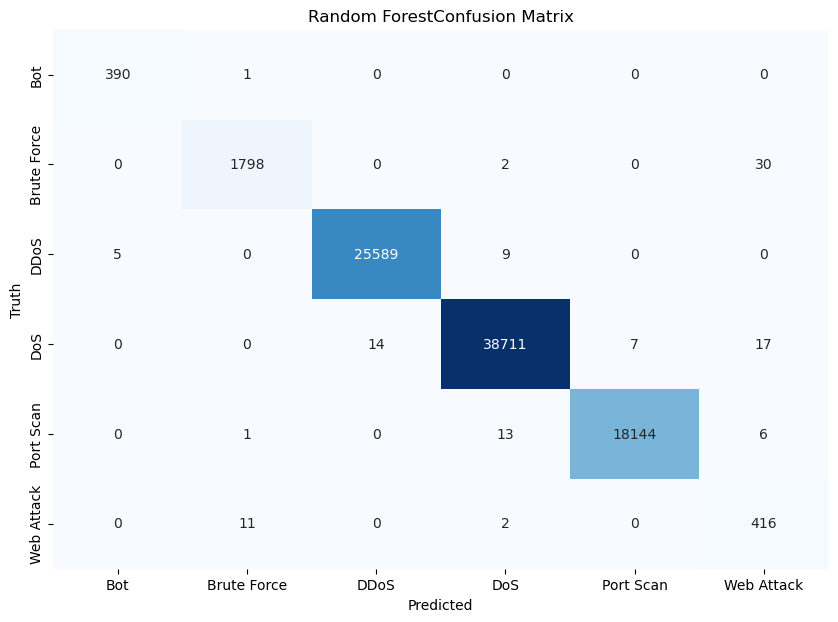

              precision    recall  f1-score   support

         Bot       0.99      1.00      0.99       391
 Brute Force       0.99      0.98      0.99      1830
        DDoS       1.00      1.00      1.00     25603
         DoS       1.00      1.00      1.00     38749
   Port Scan       1.00      1.00      1.00     18164
  Web Attack       0.89      0.97      0.93       429

    accuracy                           1.00     85166
   macro avg       0.98      0.99      0.98     85166
weighted avg       1.00      1.00      1.00     85166



['/home/wahba/Documents/nids5/test/model/multi_class/rf_multi_class.joblib']

/home/wahba/miniconda3/envs/ml1/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_tracker.py:146: UserWarning: resource_tracker: process died unexpectedly, relaunching. Some folders/semaphores might leak.
  warnings.warn(


In [5]:
best_params_rf = {'n_estimators': 150, 
                'min_samples_split': 2, 
                'min_samples_leaf': 2, 
                'max_features': 'sqrt', 
                'max_depth': 30}
cv = 5
n_jobs = -1
random_state = 42

measurement_rf = {}

rf_model = RandomForestClassifier(**best_params_rf, random_state=random_state, n_jobs=n_jobs)

# Function to monitor CPU usage during training
cpu_usage = []
stop_flag = threading.Event()

def monitor_cpu():
    while not stop_flag.is_set():
        cpu_usage.append(psutil.cpu_percent(interval=0.1))

# Function to train the model
def train_model():
    rf_model.fit(X_train_resampled, y_train_resampled)

try:
    # Start CPU monitoring in a separate thread
    cpu_thread = threading.Thread(target=monitor_cpu)
    cpu_thread.start()

    # Measure memory usage and training time
    start_time = time.time()
    train_memory_rf = max(memory_usage((train_model,)))  # Measure peak memory usage
    training_time = time.time() - start_time

    # Stop CPU monitoring
    stop_flag.set()
    cpu_thread.join()

    # Add measurements
    measurement_rf['Memory Usage (MB)'] = train_memory_rf
    measurement_rf['Training Time (s)'] = training_time
    measurement_rf['Peak CPU Usage (%)'] = max(cpu_usage)
    measurement_rf['Average CPU Usage (%)'] = sum(cpu_usage) / len(cpu_usage) if cpu_usage else 0

    # Perform cross-validation
    cv_scores_rf = cross_val_score(rf_model, X_train_resampled, y_train_resampled, cv=cv, n_jobs=n_jobs)

except Exception as e:
    print(f"Error during Random Forest training: {e}")


## Model evaluation

# Making predictions
y_pred_rf = rf_model.predict(X_test)

# Evaluating the model performance on the cross validation set vs accuracy on the test set
cv_scores_mean_rf = np.mean(cv_scores_rf)

# Accuracy
accuracy_rf = accuracy_score(y_test, y_pred_rf)

# Confustion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(10, 7))
sns.heatmap(cm_rf, annot=True, fmt='d', xticklabels=rf_model.classes_, yticklabels=rf_model.classes_, cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('Random ForestConfusion Matrix')
plt.show()

print(classification_report(y_test, y_pred_rf))

joblib.dump(rf_model, '/home/wahba/Documents/nids5/test/model/multi_class/rf_multi_class.joblib')

## 2.2 XGBoost

/home/wahba/miniconda3/envs/ml1/lib/python3.10/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(
/home/wahba/miniconda3/envs/ml1/lib/python3.10/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' varia

Cross validation average score: 0.9975 +/- standard deviation: 0.0004


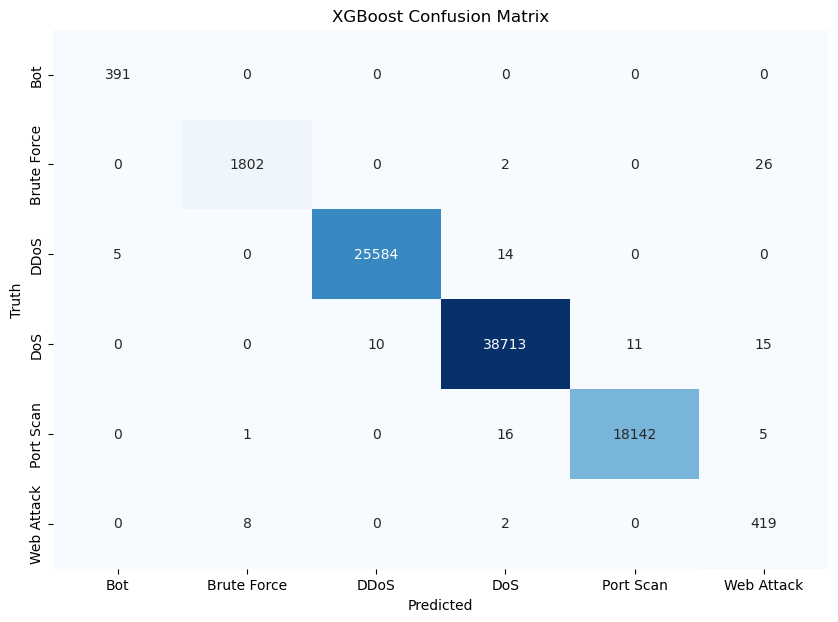

              precision    recall  f1-score   support

         Bot       0.99      1.00      0.99       391
 Brute Force       1.00      0.98      0.99      1830
        DDoS       1.00      1.00      1.00     25603
         DoS       1.00      1.00      1.00     38749
   Port Scan       1.00      1.00      1.00     18164
  Web Attack       0.90      0.98      0.94       429

    accuracy                           1.00     85166
   macro avg       0.98      0.99      0.99     85166
weighted avg       1.00      1.00      1.00     85166



['/home/wahba/Documents/nids5/test/model/multi_class/xgb_multi_class.joblib']

In [7]:
# Custom mapping for the attack types
label_mapping = {
        'DoS': 0,
        'DDoS': 1,
        'Port Scan': 2,
        'Brute Force': 3,
        'Web Attack': 4,
        'Bot': 5,
    }
y_train_resampled_mapped = y_train_resampled.map(label_mapping)
y_test_mapped = y_test.map(label_mapping)

best_params_xgb = {'subsample': 1.0, 
				'n_estimators': 100, 
				'min_child_weight': 1, 
				'max_depth': 6, 
				'learning_rate': 0.2, 
				'colsample_bytree': 1.0}
cv = 5
n_jobs = -1
random_state = 42

measurement_xgb = {}

xgb_model = xgb.XGBClassifier(**best_params_xgb, 
							objective='multi:softmax', 
							num_class=len(y_train_resampled_mapped.unique()), 
							random_state = random_state, 
							n_jobs = n_jobs)

# Function to monitor CPU usage during training
cpu_usage = []
stop_flag = threading.Event()

def monitor_cpu():
    while not stop_flag.is_set():
        cpu_usage.append(psutil.cpu_percent(interval=0.1))

# Function to train the model
def train_model():
    xgb_model.fit(X_train_resampled, y_train_resampled_mapped)

try:
    # Start CPU monitoring in a separate thread
    cpu_thread = threading.Thread(target=monitor_cpu)
    cpu_thread.start()

    # Measure memory usage and training time
    start_time = time.time()
    train_memory_xgb = max(memory_usage((train_model,)))  # Measure peak memory usage
    training_time = time.time() - start_time

    # Stop CPU monitoring
    stop_flag.set()
    cpu_thread.join()

    # Add measurements
    measurement_xgb['Memory Usage (MB)'] = train_memory_rf
    measurement_xgb['Training Time (s)'] = training_time
    measurement_xgb['Peak CPU Usage (%)'] = max(cpu_usage)
    measurement_xgb['Average CPU Usage (%)'] = sum(cpu_usage) / len(cpu_usage) if cpu_usage else 0

    # Perform cross-validation
    cv_scores_xgb = cross_val_score(xgb_model, X_train_resampled, y_train_resampled_mapped, cv = cv, n_jobs = n_jobs)

except Exception as e:
    print(f"Error during XGBoost training: {e}")

## Model evaluation

# Making predictions
y_pred_xgb = xgb_model.predict(X_test)

# Evaluating the model performance on the cross validation set vs accuracy on the test set
cv_scores_mean_xgb = np.mean(cv_scores_xgb)
print(f'Cross validation average score: {cv_scores_mean_xgb:.4f} +/- standard deviation: {np.std(cv_scores_xgb):.4f}')

# Accuracy
accuracy_xgb = accuracy_score(y_test_mapped, y_pred_xgb)

# Remapping the labels for visualization
reverse_label_mapping = {v: k for k, v in label_mapping.items()}
predicted_labels = [reverse_label_mapping[pred] for pred in y_pred_xgb]
actual_labels = sorted([reverse_label_mapping[label] for label in xgb_model.classes_])

# Confusion matrix
cm_xgb = confusion_matrix(y_test, predicted_labels)

plt.figure(figsize=(10, 7))
sns.heatmap(cm_xgb, annot=True, fmt='d', xticklabels=actual_labels, yticklabels=actual_labels, cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('XGBoost Confusion Matrix')
plt.show()

print(classification_report(y_test, predicted_labels))

joblib.dump(xgb_model, '/home/wahba/Documents/nids5/test/model/multi_class/xgb_multi_class.joblib')


## 2.3. K-Nearest Neighbour (KNN)

/home/wahba/miniconda3/envs/ml1/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_tracker.py:146: UserWarning: resource_tracker: process died unexpectedly, relaunching. Some folders/semaphores might leak.
  warnings.warn(
/home/wahba/miniconda3/envs/ml1/lib/python3.10/multiprocessing/resource_tracker.py:104: UserWarning: resource_tracker: process died unexpectedly, relaunching.  Some resources might leak.
  warnings.warn('resource_tracker: process died unexpectedly, '
Traceback (most recent call last):
  File "/home/wahba/miniconda3/envs/ml1/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_tracker.py", line 319, in main
    del registry[rtype][name]
KeyError: '/loky-28290-7or2nguy'
Traceback (most recent call last):
  File "/home/wahba/miniconda3/envs/ml1/lib/python3.10/site-packages/joblib/externals/loky/backend/resource_tracker.py", line 319, in main
    del registry[rtype][name]
KeyError: '/loky-28290-o9efqle6'
Traceback (most recent call last):


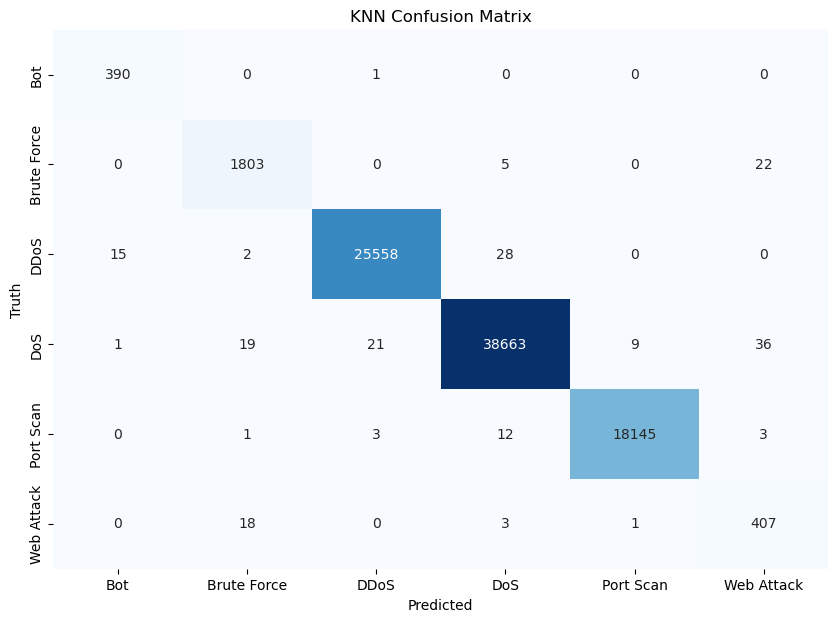

              precision    recall  f1-score   support

         Bot       0.96      1.00      0.98       391
 Brute Force       0.98      0.99      0.98      1830
        DDoS       1.00      1.00      1.00     25603
         DoS       1.00      1.00      1.00     38749
   Port Scan       1.00      1.00      1.00     18164
  Web Attack       0.87      0.95      0.91       429

    accuracy                           1.00     85166
   macro avg       0.97      0.99      0.98     85166
weighted avg       1.00      1.00      1.00     85166



['/home/wahba/Documents/nids5/test/model/multi_class/knn_multi_class.joblib']

In [13]:
best_params_knn = {'weights': 'distance', 'n_neighbors': 3}

cv = 5
n_jobs = -1 # use all available processors to run neighbours search
random_state = 42

measurement_knn = {}

knn_model = KNeighborsClassifier(**best_params_knn, n_jobs = n_jobs)

# Function to monitor CPU usage during training
cpu_usage = []
stop_flag = threading.Event()

def monitor_cpu():
    while not stop_flag.is_set():
        cpu_usage.append(psutil.cpu_percent(interval=0.1))

# Function to train the model
def train_model():
    knn_model.fit(X_train_scaled_resampled, y_train_scaled_resampled)

try:
    # Start CPU monitoring in a separate thread
    cpu_thread = threading.Thread(target=monitor_cpu)
    cpu_thread.start()

    # Measure memory usage and training time
    start_time = time.time()
    train_memory_knn = max(memory_usage((train_model,)))  # Measure peak memory usage
    training_time = time.time() - start_time

    # Stop CPU monitoring
    stop_flag.set()
    cpu_thread.join()

    # Add measurements
    measurement_knn['Memory Usage (MB)'] = train_memory_knn
    measurement_knn['Training Time (s)'] = training_time
    measurement_knn['Peak CPU Usage (%)'] = max(cpu_usage)
    measurement_knn['Average CPU Usage (%)'] = sum(cpu_usage) / len(cpu_usage) if cpu_usage else 0

    # Perform cross-validation
    cv_scores_knn = cross_val_score(knn_model, X_train_scaled_resampled, y_train_scaled_resampled, cv = cv, n_jobs = n_jobs)

except Exception as e:
    print(f"Error during KNN training: {e}")

## Model evaluation
y_pred_knn = knn_model.predict(X_test_scaled)

# Evaluating the model performance on the cross validation set vs accuracy on the test set
cv_scores_mean_knn = np.mean(cv_scores_knn)

accuracy_knn = accuracy_score(y_test, y_pred_knn)

# Evaluating the model via confusion matrix
cm_knn = confusion_matrix(y_test, y_pred_knn)

plt.figure(figsize=(10, 7))
sns.heatmap(cm_knn, annot=True, fmt='d', xticklabels=knn_model.classes_, yticklabels=knn_model.classes_, cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('KNN Confusion Matrix')
plt.show()

# Classification report
print(classification_report(y_test, y_pred_knn))

joblib.dump(knn_model, '/home/wahba/Documents/nids5/test/model/multi_class/knn_multi_class.joblib')


# 3. Model Comparisons

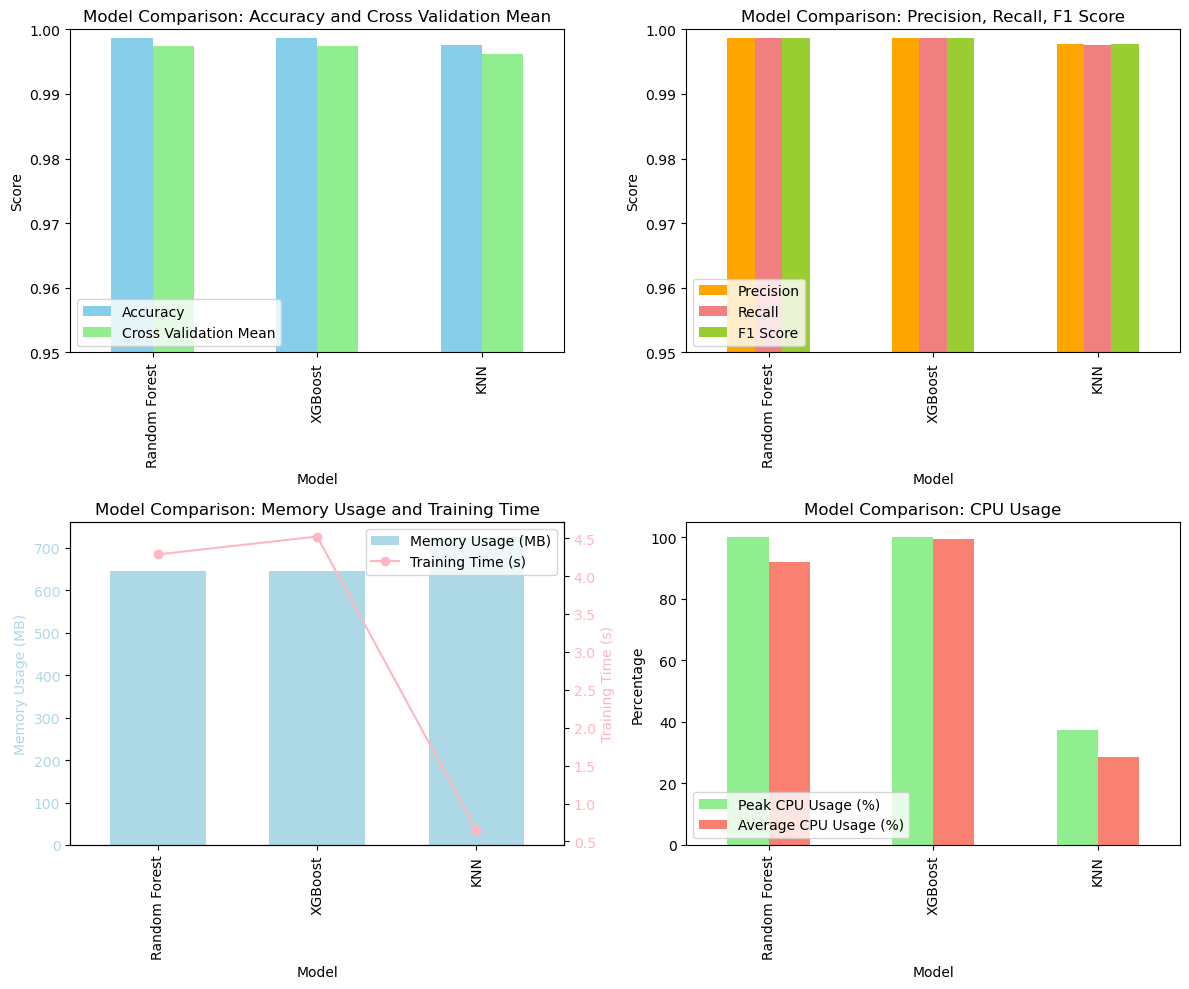

In [14]:
# Calculating precision, recall, and F1 score for each model
precision_rf = precision_score(y_test, y_pred_rf, average='weighted')
recall_rf = recall_score(y_test, y_pred_rf, average='weighted')
f1_rf = f1_score(y_test, y_pred_rf, average='weighted')

precision_xgb = precision_score(y_test_mapped, y_pred_xgb, average='weighted')
recall_xgb = recall_score(y_test_mapped, y_pred_xgb, average='weighted')
f1_xgb = f1_score(y_test_mapped, y_pred_xgb, average='weighted')

precision_knn = precision_score(y_test, y_pred_knn, average='weighted')
recall_knn = recall_score(y_test, y_pred_knn, average='weighted')
f1_knn = f1_score(y_test, y_pred_knn, average='weighted')

# Creating the results dataframe
supervised_results = pd.DataFrame({
    'Model': ['Random Forest', 'XGBoost', 'KNN'],
    'Accuracy': [accuracy_rf, accuracy_xgb, accuracy_knn],
    'Cross Validation Mean': [cv_scores_mean_rf, cv_scores_mean_xgb, cv_scores_mean_knn],
    'Precision': [precision_rf, precision_xgb, precision_knn],
    'Recall': [recall_rf, recall_xgb, recall_knn],
    'F1 Score': [f1_rf, f1_xgb, f1_knn],
    'Memory Usage (MB)': [measurement_rf['Memory Usage (MB)'], measurement_xgb['Memory Usage (MB)'], measurement_knn['Memory Usage (MB)']],
    'Training Time (s)': [measurement_rf['Training Time (s)'], measurement_xgb['Training Time (s)'], measurement_knn['Training Time (s)']],
    'Peak CPU Usage (%)': [measurement_rf['Peak CPU Usage (%)'], measurement_xgb['Peak CPU Usage (%)'], measurement_knn['Peak CPU Usage (%)']],
    'Average CPU Usage (%)': [measurement_rf['Average CPU Usage (%)'], measurement_xgb['Average CPU Usage (%)'], measurement_knn['Average CPU Usage (%)']],
})

# Plotting the comparison for accuracy, cross-validation, and metrics
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plotting Accuracy and Cross Validation Mean
supervised_results.set_index('Model')[['Accuracy', 'Cross Validation Mean']].plot(kind='bar', ax=axes[0, 0], color=['skyblue', 'lightgreen'], legend=True)
axes[0, 0].set_title('Model Comparison: Accuracy and Cross Validation Mean')
axes[0, 0].set_ylabel('Score')
axes[0, 0].set_xlabel('Model')
axes[0, 0].set_ylim(0.95, 1.0)
axes[0, 0].legend(loc='lower left')

# Plotting Precision, Recall, F1 Score
supervised_results.set_index('Model')[['Precision', 'Recall', 'F1 Score']].plot(kind='bar', ax=axes[0, 1], color=['orange', 'lightcoral', 'yellowgreen'], legend=True)
axes[0, 1].set_title('Model Comparison: Precision, Recall, F1 Score')
axes[0, 1].set_ylabel('Score')
axes[0, 1].set_xlabel('Model')
axes[0, 1].set_ylim(0.95, 1.0)
axes[0, 1].legend(loc='lower left')

# Plotting Memory Usage and Training Time
ax1 = axes[1, 0]

supervised_results.set_index('Model')['Memory Usage (MB)'].plot(
    kind='bar', ax=ax1, color='lightblue', label='Memory Usage (MB)', width=0.6
)
ax1.set_ylabel('Memory Usage (MB)', color='lightblue')
ax1.tick_params(axis='y', labelcolor='lightblue')

ax2 = ax1.twinx() 
supervised_results.set_index('Model')['Training Time (s)'].plot(
    ax=ax2, color='lightpink', marker='o', label='Training Time (s)'
)
ax2.set_ylabel('Training Time (s)', color='lightpink')
ax2.tick_params(axis='y', labelcolor='lightpink')

ax1.set_title('Model Comparison: Memory Usage and Training Time')
ax1.set_xlabel('Model')

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper right')

# Plotting Peak and Average CPU Usage
supervised_results.set_index('Model')[['Peak CPU Usage (%)', 'Average CPU Usage (%)']].plot(kind='bar', ax=axes[1, 1], color=['lightgreen', 'salmon'], legend=True)
axes[1, 1].set_title('Model Comparison: CPU Usage')
axes[1, 1].set_ylabel('Percentage')
axes[1, 1].set_xlabel('Model')
axes[1, 1].legend(loc='lower left')

plt.tight_layout()
plt.show()